In [60]:
# General imports
import numpy as np

from qiskit import QuantumCircuit,  QuantumRegister, ClassicalRegister, transpile

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# Quantum circuit simulators
from qiskit.primitives import Estimator, Sampler

# Parameterized circuit
from qiskit.circuit import Parameter

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram


SparsePauliOp(['ZZ', 'IX', 'XI'],
              coeffs=[ 1.+0.j, -1.+0.j, -1.+0.j])

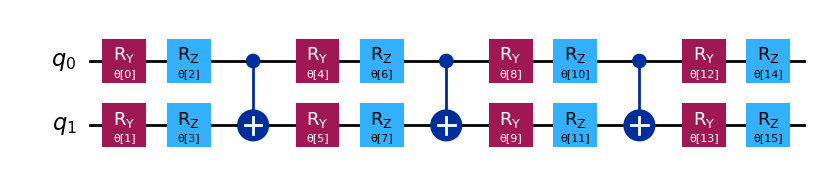

In [98]:
# Define Spin-1/2 Hamiltonian and Variational Ansatz
num_sites = 2
J = 1
h = -1

oplist = []
for i in range(num_sites-1):
    oplist.append(("ZZ",[i,i+1],J))
for i in range(num_sites):
    oplist.append(("X",[i],h))    

hamiltonian = SparsePauliOp.from_sparse_list([*oplist], num_qubits=num_sites)
display(hamiltonian)
ansatz = EfficientSU2(hamiltonian.num_qubits)
display(ansatz.decompose().draw("mpl", style="iqp"))
num_params = ansatz.num_parameters

In [99]:
# Defien free energy calculation to be minimize based on ansatz parameters
def cost_func(params, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler):
    free_energy = 0
    
    # Expectation value of H
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    free_energy += energy-3/(2*beta)

    # Calculation and post-processing of Tr(rho^2)
    job2 = sampler.run(tr_rho2, parameter_values=params).result()
    R2 = job2.quasi_dists[0][0] - job2.quasi_dists[0][1]
    free_energy += (2/beta)*R2

    # Calculation and post-processing of Tr(rho^3)
    job3 = sampler.run(tr_rho3, parameter_values=params).result()
    R3 = job3.quasi_dists[0][0] - job3.quasi_dists[0][1]
    free_energy += (-1/(2*beta))*R3
    
    return free_energy

In [100]:
# Define
def build_callback(ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler, callback_dict):
    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            cost_func(current_vector, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler)
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback


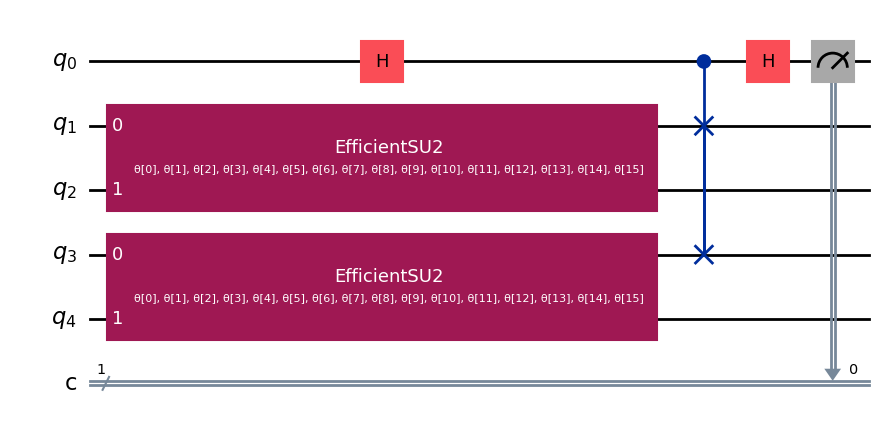

In [101]:
# Define SWAP test circuit used in Tr(rho^2) calcultion
aux = QuantumCircuit(1,1)
tr_rho2 = QuantumCircuit(2*num_sites+1)
tr_rho2.compose(aux, [0], inplace=True)
tr_rho2.compose(ansatz, [i+1 for i in range(num_sites)], inplace=True)
tr_rho2.compose(ansatz, [i+1+num_sites for i in range(num_sites)], inplace=True)
tr_rho2.h(0)
tr_rho2.cswap(0,1,num_sites+1)
tr_rho2.h(0)
tr_rho2.measure(0,0)
display(tr_rho2.draw("mpl", style="iqp"))

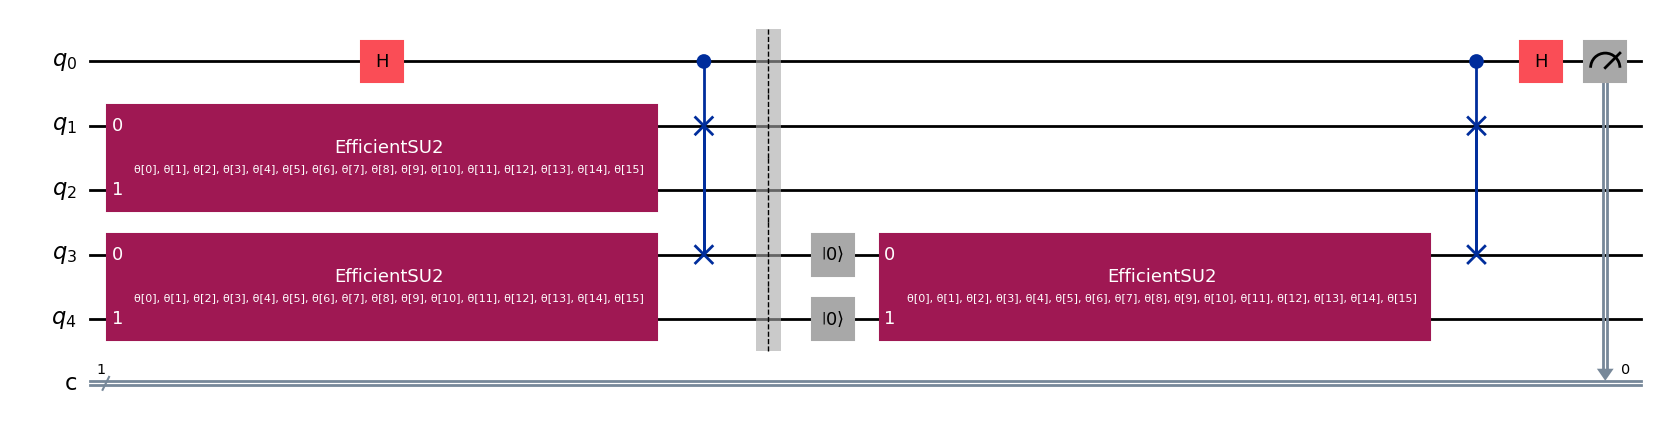

In [102]:
# Define SWAP test circuit used in Tr(rho^3) calcultion using mid-circuit measurment and reset
aux = QuantumCircuit(1,1)
tr_rho3 = QuantumCircuit(2*num_sites+1)
tr_rho3.compose(aux, [0], inplace=True)
tr_rho3.compose(ansatz, [i+1 for i in range(num_sites)], inplace=True)
tr_rho3.compose(ansatz, [i+1+num_sites for i in range(num_sites)], inplace=True)
tr_rho3.h(0)
tr_rho3.cswap(0,1,num_sites+1)
tr_rho3.barrier()
tr_rho3.reset([1+num_sites,2+num_sites])
tr_rho3.compose(ansatz, [i+1+num_sites for i in range(num_sites)], inplace=True)
tr_rho3.cswap(0,1,num_sites+1)
tr_rho3.h(0)
tr_rho3.measure(0,0)
display(tr_rho3.draw("mpl", style="iqp"))


In [104]:
# Minimize the cost function with respect to the ansatz parameters
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

x0 = 2 * np.pi * np.random.random(num_params)
beta = 1.5
estimator = Estimator()
sampler = Sampler()
callback = build_callback(ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler, callback_dict)
res = minimize(
    cost_func,
    x0,
    args=(ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler),
    method="cobyla",
    callback=callback,
    options={'maxiter':1000}
)
display(f'Calculated Free Energy: {cost_func(res.x, ansatz, tr_rho2, tr_rho3, hamiltonian, beta, estimator, sampler)}')



'Calculated Free Energy: -2.3291976432715256'